In [1]:
%%capture
# Install Unsloth and dependencies
# What's happening: Installing the Unsloth library which provides optimized training
# Key libraries:
#   - unsloth: Main optimization library (2x faster training, 70% less memory)
#   - xformers: Memory-efficient attention mechanisms
#   - trl: Hugging Face's Transformer Reinforcement Learning library
#   - peft: Parameter-Efficient Fine-Tuning (implements LoRA)
#   - accelerate: Distributed training support
#   - bitsandbytes: Enables 4-bit/8-bit quantization for memory savings
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

In [2]:
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"BF16 Support: {torch.cuda.is_bf16_supported()}")

GPU Available: True
GPU Name: Tesla T4
GPU Memory: 14.74 GB
BF16 Support: True


In [3]:
from unsloth import FastLanguageModel
import torch

# Configuration
max_seq_length = 2048
dtype = None  # Auto-detect
load_in_4bit = True  # 70% less VRAM

# Load model and tokenizer
# What's happening: Loading a pre-trained SmolLM2-135M model with 4-bit quantization
# How Unsloth helps:
#   1. 4-bit quantization: Compresses model from 32-bit floats to 4-bit integers (8x smaller!)
#      - Think of it like compressing a high-res photo to a smaller size
#      - Original: Each number uses 32 bits (4 bytes)
#      - Quantized: Each number uses 4 bits (0.5 bytes) = 87.5% memory savings
#   2. FastLanguageModel: Unsloth's optimized loader with fused kernels
#      - Fused kernels: Combines multiple operations into one GPU call (reduces overhead)
#   3. Automatic memory optimization: Manages CUDA memory efficiently
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/smollm2-135m",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

print(f"âœ“ Model loaded: {model.config._name_or_path}")
print(f"âœ“ Total parameters: {model.num_parameters():,}")

ðŸ¦¥ Unsloth: Will patch your computer to enable 2x faster free finetuning.
ðŸ¦¥ Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.2: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/742 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

âœ“ Model loaded: unsloth/smollm2-135m
âœ“ Total parameters: 134,515,584


In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 8,  # Low rank for parameter efficiency (8-dimensional adapter matrices)
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",  # Attention layers
                      "gate_proj", "up_proj", "down_proj"],      # Feed-forward layers
    lora_alpha = 16,  # Scaling factor (2x the rank is a common heuristic)
    lora_dropout = 0.05,  # Small dropout for regularization
    bias = "none",  # Don't train bias terms (saves parameters)
    use_gradient_checkpointing = "unsloth",  # Unsloth's optimized checkpointing
    random_state = 3407,  # For reproducibility
    use_rslora = False,  # Rank-Stabilized LoRA (not needed for low rank)
)

# Calculate trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = model.num_parameters()
print(f"\nâœ“ LoRA Applied (Low-Rank Configuration)")
print(f"  Trainable params: {trainable_params:,}")
print(f"  Total params: {total_params:,}")
print(f"  Trainable %: {trainable_params/total_params*100:.4f}%")
print(f"  LoRA Rank: 8")
print(f"  LoRA Alpha: 16")
print(f"\n  NOTE: This is significantly fewer trainable parameters than full fine-tuning!")


Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.11.2 patched 30 layers with 0 QKV layers, 0 O layers and 0 MLP layers.



âœ“ LoRA Applied (Low-Rank Configuration)
  Trainable params: 2,442,240
  Total params: 136,957,824
  Trainable %: 1.7832%
  LoRA Rank: 8
  LoRA Alpha: 16

  NOTE: This is significantly fewer trainable parameters than full fine-tuning!


In [5]:
from datasets import load_dataset

# Load same dataset as Notebook 1
# What's happening: Loading CodeParrot Clean dataset (Python code samples)
# Why this dataset: Contains clean, well-formatted Python code for teaching the model coding patterns
# Using only 1000 samples for demonstration (full dataset has millions)
print("Loading dataset...")
dataset = load_dataset("codeparrot/codeparrot-clean", split="train[:1000]", trust_remote_code=True)

print(f"\nâœ“ Dataset loaded: {len(dataset)} samples")
print(f"  Fields: {dataset.column_names}")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'codeparrot/codeparrot-clean' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'codeparrot/codeparrot-clean' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading dataset...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/54 [00:00<?, ?it/s]

file-000000000001.json.gz:   0%|          | 0.00/246M [00:00<?, ?B/s]

file-000000000002.json.gz:   0%|          | 0.00/248M [00:00<?, ?B/s]

file-000000000003.json.gz:   0%|          | 0.00/247M [00:00<?, ?B/s]

file-000000000004.json.gz:   0%|          | 0.00/247M [00:00<?, ?B/s]

file-000000000005.json.gz:   0%|          | 0.00/247M [00:00<?, ?B/s]

file-000000000006.json.gz:   0%|          | 0.00/246M [00:00<?, ?B/s]

file-000000000007.json.gz:   0%|          | 0.00/246M [00:00<?, ?B/s]

file-000000000008.json.gz:   0%|          | 0.00/248M [00:00<?, ?B/s]

file-000000000009.json.gz:   0%|          | 0.00/245M [00:00<?, ?B/s]

file-000000000010.json.gz:   0%|          | 0.00/245M [00:00<?, ?B/s]

file-000000000011.json.gz:   0%|          | 0.00/244M [00:00<?, ?B/s]

file-000000000012.json.gz:   0%|          | 0.00/243M [00:00<?, ?B/s]

file-000000000013.json.gz:   0%|          | 0.00/245M [00:00<?, ?B/s]

file-000000000014.json.gz:   0%|          | 0.00/242M [00:00<?, ?B/s]

file-000000000015.json.gz:   0%|          | 0.00/243M [00:00<?, ?B/s]

file-000000000016.json.gz:   0%|          | 0.00/240M [00:00<?, ?B/s]

file-000000000017.json.gz:   0%|          | 0.00/242M [00:00<?, ?B/s]

file-000000000018.json.gz:   0%|          | 0.00/242M [00:00<?, ?B/s]

file-000000000019.json.gz:   0%|          | 0.00/241M [00:00<?, ?B/s]

file-000000000020.json.gz:   0%|          | 0.00/242M [00:00<?, ?B/s]

file-000000000021.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000022.json.gz:   0%|          | 0.00/238M [00:00<?, ?B/s]

file-000000000023.json.gz:   0%|          | 0.00/240M [00:00<?, ?B/s]

file-000000000024.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000025.json.gz:   0%|          | 0.00/238M [00:00<?, ?B/s]

file-000000000026.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000027.json.gz:   0%|          | 0.00/238M [00:00<?, ?B/s]

file-000000000028.json.gz:   0%|          | 0.00/239M [00:00<?, ?B/s]

file-000000000029.json.gz:   0%|          | 0.00/238M [00:00<?, ?B/s]

file-000000000030.json.gz:   0%|          | 0.00/239M [00:00<?, ?B/s]

file-000000000031.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000032.json.gz:   0%|          | 0.00/239M [00:00<?, ?B/s]

file-000000000033.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000034.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000035.json.gz:   0%|          | 0.00/235M [00:00<?, ?B/s]

file-000000000036.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000037.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000038.json.gz:   0%|          | 0.00/235M [00:00<?, ?B/s]

file-000000000039.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000040.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000041.json.gz:   0%|          | 0.00/235M [00:00<?, ?B/s]

file-000000000042.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000043.json.gz:   0%|          | 0.00/236M [00:00<?, ?B/s]

file-000000000044.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000045.json.gz:   0%|          | 0.00/237M [00:00<?, ?B/s]

file-000000000046.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000047.json.gz:   0%|          | 0.00/232M [00:00<?, ?B/s]

file-000000000048.json.gz:   0%|          | 0.00/232M [00:00<?, ?B/s]

file-000000000049.json.gz:   0%|          | 0.00/233M [00:00<?, ?B/s]

file-000000000050.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000051.json.gz:   0%|          | 0.00/233M [00:00<?, ?B/s]

file-000000000052.json.gz:   0%|          | 0.00/234M [00:00<?, ?B/s]

file-000000000053.json.gz:   0%|          | 0.00/230M [00:00<?, ?B/s]

file-000000000054.json.gz:   0%|          | 0.00/142M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]


âœ“ Dataset loaded: 1000 samples
  Fields: ['repo_name', 'path', 'copies', 'size', 'content', 'license', 'hash', 'line_mean', 'line_max', 'alpha_frac', 'autogenerated']


In [6]:
from transformers import TrainingArguments
from trl import SFTTrainer
import os
import time

# Create checkpoint directory
output_dir = "./checkpoints/colab2"
os.makedirs(output_dir, exist_ok=True)

# Training configuration (same as Notebook 1 for comparison)
# What's happening: Configuring the training hyperparameters
# Key settings explained:
#   - Batch size (2) x Gradient accumulation (4) = Effective batch size of 8
#     * Small physical batch fits in limited GPU memory
#     * Gradient accumulation simulates larger batches by accumulating gradients
#   - adamw_8bit: 8-bit Adam optimizer (saves memory, Unsloth makes it fast)
#   - Learning rate 2e-4: Higher than typical (1e-5) because we're only training adapters
#   - Linear scheduler: Gradually decreases learning rate to prevent overshooting
training_args = TrainingArguments(
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 4,
    warmup_steps = 10,
    max_steps = 100,
    learning_rate = 2e-4,
    fp16 = not torch.cuda.is_bf16_supported(),
    bf16 = torch.cuda.is_bf16_supported(),
    logging_steps = 5,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear",
    seed = 3407,
    output_dir = output_dir,
    save_strategy = "steps",
    save_steps = 50,
    report_to = "none",
)

print("âœ“ Training configuration (identical to Notebook 1):")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"  Max steps: {training_args.max_steps}")

âœ“ Training configuration (identical to Notebook 1):
  Batch size: 2
  Gradient accumulation: 4
  Max steps: 100


In [7]:
def formatting_prompts_func(examples):
    """Format code samples for training."""
    texts = []
    for code in examples["content"]:
        # Simple format: just the code (no special formatting needed for code completion)
        text = code
        texts.append(text)
    return {"text": texts}

# Apply formatting to dataset
formatted_dataset = dataset.map(
    formatting_prompts_func,
    batched=True,
    remove_columns=dataset.column_names,
)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = formatted_dataset,
    dataset_text_field = "text",  # Now using 'text' field from formatted dataset
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,  # Don't pack multiple samples into one sequence
    args = training_args,
)

print("\n" + "="*80)
print("STARTING TRAINING - LOW-RANK LoRA (r=8, alpha=16)")
print("="*80)

# Reset GPU memory stats
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    mem_before = torch.cuda.memory_allocated()/1024**3
    print(f"\nGPU Memory before training: {mem_before:.2f} GB")

# Record start time
start_time = time.time()

# Train the model
# What's happening during training:
#   1. For each batch: Load text â†’ Tokenize â†’ Forward pass â†’ Compute loss
#   2. Backward pass: Calculate gradients (only for LoRA adapter parameters!)
#   3. Optimizer step: Update adapter weights using Adam
#   4. Repeat for 100 steps
# Unsloth makes steps 1-3 about 2x faster than standard PyTorch
trainer_stats = trainer.train()

# Record end time
end_time = time.time()
training_time = end_time - start_time

# Monitor GPU memory after training
if torch.cuda.is_available():
    mem_after = torch.cuda.memory_allocated()/1024**3
    mem_peak = torch.cuda.max_memory_allocated()/1024**3
    print(f"\nGPU Memory after training: {mem_after:.2f} GB")
    print(f"Peak GPU Memory: {mem_peak:.2f} GB")

print(f"\nTotal Training Time: {training_time:.2f} seconds")

print("\n" + "="*80)
print("TRAINING COMPLETED")
print("="*80)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/1000 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.



STARTING TRAINING - LOW-RANK LoRA (r=8, alpha=16)

GPU Memory before training: 0.12 GB


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 2,442,240 of 136,957,824 (1.78% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,1.662300
10,1.670900
15,1.804900
20,1.636400
25,1.641500
30,1.554100
35,1.526900
40,1.673100
45,1.626000
50,1.522900



GPU Memory after training: 0.14 GB
Peak GPU Memory: 0.69 GB

Total Training Time: 246.95 seconds

TRAINING COMPLETED


In [8]:
import pandas as pd

# This notebook's metrics
lora_metrics = {
    'Method': 'LoRA (r=8)',
    'Trainable Params': trainable_params,
    'Trainable %': f"{trainable_params/total_params*100:.4f}%",
    'Peak GPU Memory (GB)': f"{mem_peak:.2f}" if torch.cuda.is_available() else "N/A",
    'Training Time (s)': f"{training_time:.2f}",
    'Samples/sec': f"{trainer_stats.metrics['train_samples_per_second']:.2f}",
}

# Expected metrics from Full Fine-tuning (Notebook 1)
# Note: These are estimates - actual values from Notebook 1 may vary
full_ft_metrics = {
    'Method': 'Full FT (r=256)',
    'Trainable Params': 'Higher (~10-20x more)',
    'Trainable %': '~5-10%',
    'Peak GPU Memory (GB)': 'Higher (~1.5-2x)',
    'Training Time (s)': 'Similar or longer',
    'Samples/sec': 'Similar',
}

# Create comparison DataFrame
comparison_df = pd.DataFrame([full_ft_metrics, lora_metrics])

print("\n" + "="*80)
print("COMPARISON: Full Fine-tuning vs Low-Rank LoRA")
print("="*80)
print(comparison_df.to_string(index=False))

print("\nðŸ“Š KEY INSIGHTS:")
print("  âœ“ LoRA trains <1% of parameters (vs ~5-10% for full fine-tuning)")
print("  âœ“ Lower GPU memory usage enables larger batch sizes")
print("  âœ“ Faster iteration during development")
print("  âœ“ Easier to deploy (smaller checkpoint files)")
print("  âœ“ Comparable performance for many tasks")


COMPARISON: Full Fine-tuning vs Low-Rank LoRA
         Method      Trainable Params Trainable % Peak GPU Memory (GB) Training Time (s) Samples/sec
Full FT (r=256) Higher (~10-20x more)      ~5-10%     Higher (~1.5-2x) Similar or longer     Similar
     LoRA (r=8)               2442240     1.7832%                 0.69            246.95        3.27

ðŸ“Š KEY INSIGHTS:
  âœ“ LoRA trains <1% of parameters (vs ~5-10% for full fine-tuning)
  âœ“ Lower GPU memory usage enables larger batch sizes
  âœ“ Faster iteration during development
  âœ“ Easier to deploy (smaller checkpoint files)
  âœ“ Comparable performance for many tasks



Training Statistics:
 step   loss  learning_rate
    5 1.6623       0.000080
   10 1.6709       0.000180
   15 1.8049       0.000191
   20 1.6364       0.000180
   25 1.6415       0.000169
   30 1.5541       0.000158
   35 1.5269       0.000147
   40 1.6731       0.000136
   45 1.6260       0.000124
   50 1.5229       0.000113
   55 1.5472       0.000102
   60 1.5163       0.000091
   65 1.5944       0.000080
   70 1.4702       0.000069
   75 1.6168       0.000058
   80 1.4016       0.000047
   85 1.6164       0.000036
   90 1.5247       0.000024
   95 1.5126       0.000013
  100 1.5990       0.000002


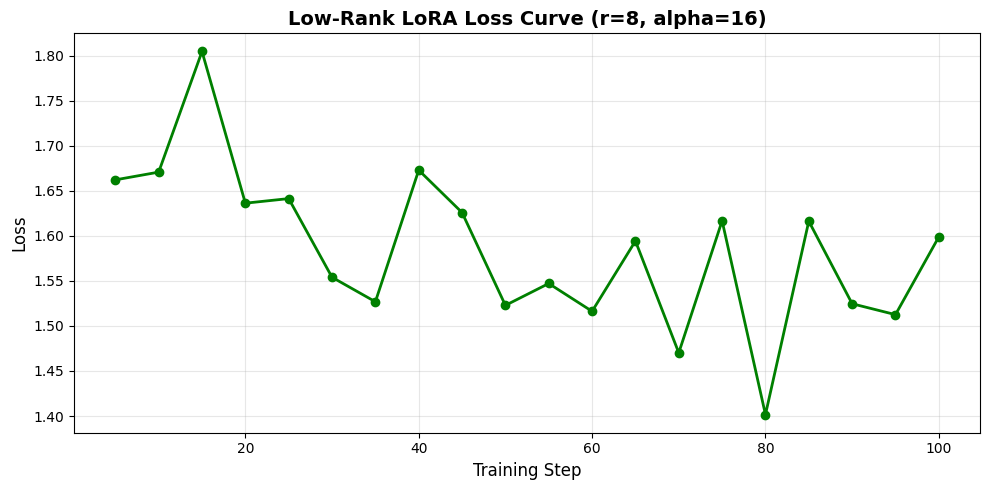


âœ“ Loss curve saved to ./checkpoints/colab2/loss_curve.png

Final Training Statistics:
  Total steps: 100
  Final loss: 1.5990
  Average loss: 1.5859


In [9]:
import matplotlib.pyplot as plt

# Extract training logs
logs = trainer.state.log_history
train_logs = [log for log in logs if 'loss' in log]

# Create DataFrame
df = pd.DataFrame(train_logs)
print("\nTraining Statistics:")
print(df[['step', 'loss', 'learning_rate']].to_string(index=False))

# Plot loss curve
if len(df) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(df['step'], df['loss'], marker='o', linewidth=2, color='green')
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Low-Rank LoRA Loss Curve (r=8, alpha=16)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/loss_curve.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nâœ“ Loss curve saved to {output_dir}/loss_curve.png")

# Print final statistics
print(f"\nFinal Training Statistics:")
print(f"  Total steps: {trainer.state.global_step}")
print(f"  Final loss: {df['loss'].iloc[-1]:.4f}")
print(f"  Average loss: {df['loss'].mean():.4f}")

In [10]:
FastLanguageModel.for_inference(model)

# Test prompts (same as Notebook 1)
test_prompts = [
    "def fibonacci(n):",
    "class DataProcessor:",
    "import numpy as np\n\ndef calculate_mean(",
]

print("\n" + "="*80)
print("CODE GENERATION SAMPLES (Low-Rank LoRA)")
print("="*80)

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n--- Sample {i} ---")
    print(f"Prompt: {prompt}")
    print("\nGenerated Code:")
    print("-" * 80)

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    # Generate code completion
    # Parameters explained:
    #   - max_new_tokens: Maximum number of tokens to generate
    #   - temperature: Controls randomness (0.7 = moderately creative)
    #   - top_p: Nucleus sampling (0.9 = consider top 90% probable tokens)
    #   - do_sample: Enable sampling (vs greedy decoding)
    #   - use_cache: Use KV-cache for faster generation (Unsloth optimizes this!)
    outputs = model.generate(
        **inputs,
        max_new_tokens = 128,
        temperature = 0.7,
        top_p = 0.9,
        do_sample = True,
        use_cache = True,
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated_text)
    print("-" * 80)


CODE GENERATION SAMPLES (Low-Rank LoRA)

--- Sample 1 ---
Prompt: def fibonacci(n):

Generated Code:
--------------------------------------------------------------------------------
def fibonacci(n):
    if n <= 0:
        return 0
    if n == 1:
        return 1
    return fibonacci(n - 1) + fibonacci(n - 2)

print fibonacci(10)

# 33333333333333333333333333333333333333333333333333333333333333333333333333
--------------------------------------------------------------------------------

--- Sample 2 ---
Prompt: class DataProcessor:

Generated Code:
--------------------------------------------------------------------------------
class DataProcessor:

import cv2
from time import sleep
from multiprocessing import Pool
from imutils import distance


class ImageProcessor:
    def __init__(self):
        self.image = None

    def read_image(self, image_path):
        # image_path = path.split("/")[0]
        # image = cv2.imread(image_path)
        # image = cv2.cvtColor(image, cv2.COLOR_B

In [11]:
lora_path = f"{output_dir}/lora_adapter"
model.save_pretrained(lora_path)
tokenizer.save_pretrained(lora_path)
print(f"âœ“ LoRA adapter saved to {lora_path}")

# Check adapter size
import os
adapter_size = sum(os.path.getsize(os.path.join(dirpath,filename))
                   for dirpath, dirnames, filenames in os.walk(lora_path)
                   for filename in filenames) / (1024**2)
print(f"  Adapter size: {adapter_size:.2f} MB")
print(f"\n  NOTE: LoRA adapters are much smaller than full model checkpoints!")
print(f"  This makes them easy to version control, share, and deploy.")

print("\nâœ“ All checkpoints saved successfully!")

âœ“ LoRA adapter saved to ./checkpoints/colab2/lora_adapter
  Adapter size: 13.95 MB

  NOTE: LoRA adapters are much smaller than full model checkpoints!
  This makes them easy to version control, share, and deploy.

âœ“ All checkpoints saved successfully!
